# <center> <span style="font-family: Virgil GS, sans-serif; color:navyblue">TabNet Credit Risk</span> </center>

 <span style="font-family: Virgil GS, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss
from scipy.special import expit as sigmoid, logit
import matplotlib.pyplot as plt

In [3]:
plt.rcParams["font.family"] = "Virgil GS"

In [4]:
url = (
    "https://drive.google.com/file/d/1Is8UZnPRExI-SLJMle8GRbFGpha5IvYZ/view?usp=sharing"
)
url = "https://drive.google.com/uc?id=" + url.split("/")[-2]
dataset = pd.read_csv(url, index_col=False)

In [5]:
features = [
    'external_risk_estimate',
    'revolving_utilization_of_unsecured_lines',
    'account_never_delinq_percent',
    'net_fraction_revolving_burden'
    ]

target = 'is_bad'

In [6]:
X = dataset[features + [target]].copy()
y = X.pop("is_bad")
X.replace([-9, -8, -7], 0, inplace=True)

ix_train, ix_test = train_test_split(X.index, test_size=0.3, random_state=62)

In [7]:
lr_model = LogisticRegression()
lr_model.fit(X.loc[ix_train], y.loc[ix_train])

pred = lr_model.predict_proba(X.loc[ix_test])[:,1]
auc_score = roc_auc_score(y.loc[ix_test], pred)
print(f"Gini score: {auc_score*2-1:.2%}")

Gini score: 79.02%


In [14]:
X_trn, y_trn = X.loc[ix_train].to_numpy(), y.loc[ix_train].to_numpy()
X_tst, y_tst = X.loc[ix_test].to_numpy(), y.loc[ix_test].to_numpy()

### <span style="font-family: Virgil GS, sans-serif; color:navyblue">Logistic regression</span>

In [15]:
import numpy as np
from typing import List
from scipy.optimize import minimize


class LogisticRegressionCustomLoss:
    
    """
    Custom implementation of logistic regression using first-order approximation with gradient descent.
    
    This class allows you to perform logistic regression with various loss functions, including:
    1. Cross-Entropy ("ce"): Standard logistic regression.
    2. Weighted Cross-Entropy ("weighted_ce"): Adds class weights to balance the loss.
    3. Focal Cross-Entropy ("focal_ce"): Introduces focal loss to focus on hard-to-classify examples.
    4. Normalized Cross-Entropy ("normalized_ce"): Normalizes the loss based on background click-through rate.
    
    Parameters:
    - learning_rate (float): The learning rate for gradient descent (default: 0.001).
    - n_iterations (int): The number of iterations for training (default: 100).
    - regularization (str): The type of regularization, either "l1" or "l2" (default: None).
    - reg_param (float): The regularization parameter (default: 0.5).
    - use_bias (bool): Whether to fit a bias term (default: False).
    - objective (str): The choice of loss function ("ce," "weighted_ce," "focal_ce," or "normalized_ce").
    - alpha (float): The weighting factor for positive class samples in "weighted_ce" (default: 1.0).
    - gamma (float): The focusing parameter for "focal_ce" (default: 0.0).
    - bias_init (float): initialization parameter for bias (default: 0.0).
    
    Sources:
    [1] 2014. Xinran He, Stuart Bowers, Joaquin Quiñonero Candela, Junfeng Pan, Ou Jin, Tianbing Xu, Bo Liu, Tao Xu, Yanxin Shi, Antoine Atallah, and Ralf Herbrich. 
        Practical Lessons from Predicting Clicks on Ads at Facebook. Proceedings of 20th ACM SIGKDD Conference on Knowledge Discovery and Data Mining - ADKDD'14.
    [2] 2017. Tsung-Yi Lin, Priya Goyal, Ross Girshick, Kaiming He, and Piotr Dollár. 2017. Focal Loss for Dense Object Detection.
    [3] 2019. Logistic Regression From Scratch. Data Science, Machine Learning, Deep Learning. Alpha-quantum.com.
    [4] 2020. Chen Wang, Chengyuan Deng, and Shuzhen Wang. Imbalance-XGBoost: Leveraging Weighted and Focal Losses for Binary Label-Imbalanced Classification with XGBoost.

    """
    
    def __init__(
        self, learning_rate: float = 0.001, n_iterations: int = 100, regularization: str = None, 
        reg_param: float = 0.5, use_bias: bool = False, objective: str = 'ce', alpha: float = 1.0, gamma: float = 0.0,
        bias_init: float = 1.0):
        
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.regularization = regularization
        self.reg_param = reg_param
        self.use_bias = use_bias
        self.objective = objective
        self.alpha = alpha
        self.gamma = gamma
        self.bias_init = bias_init
        self.calibration_scalar = 0.0

    def _initialize_weights(self, n_features: int):
        # Initialize weights with zeros
        self.weights =  np.zeros(n_features)
        # Initialize a bias
        self.bias = self.bias_init if self.use_bias else None
       
    def _sigmoid(self, z: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-z))

    def _add_regularization(self, gradient: np.ndarray) -> np.ndarray:
        if self.regularization == 'l1':
            gradient -= self.reg_param * np.sign(self.weights)
        elif self.regularization == 'l2':
            gradient -= 2 * self.reg_param * self.weights
        return gradient

    def fit(self, X: np.ndarray, y: np.ndarray) -> 'LogisticRegressionCustomLoss':
                    
        if self.use_bias:
            ones = np.ones((X.shape[0], 1))
            bias_vector = self.bias_init * np.ones((X.shape[0], 1))
            X = np.column_stack((X, bias_vector))
        else:
            ones = np.ones((X.shape[0], 1))
            X = np.column_stack((X, ones))

        n_samples, n_features = X.shape
        self._initialize_weights(n_features)

        for _ in range(self.n_iterations):
            
            y_logit = np.dot(X, self.weights)
            y_pred = self._sigmoid(y_logit)
        
            if self.objective == 'ce':
                gradient = -np.dot(X.T, (y - y_pred)) / n_samples
            elif self.objective == 'weighted_ce':
                weights = np.where(y == 1, self.alpha, 1)
                gradient = -np.dot(X.T, weights * (y - y_pred)) / n_samples
            elif self.objective == 'focal_ce':
                p_t = np.where(y == 1, y_pred, 1 - y_pred)
                gradient = -np.dot(X.T, (1 - p_t) ** self.gamma * (y - y_pred)) / n_samples
            elif self.objective == 'normalized_ce':
                background_ctr = np.mean(y)
                weights_ctr = np.where(y == 1, np.log(background_ctr), np.log(1-background_ctr))
                y_logit_ctr = np.where(y == 1, background_ctr * weights_ctr, (1-background_ctr) * weights_ctr)
                y_pred_ctr = self._sigmoid(y_logit_ctr)
                gradient = -np.dot(X.T, (y - (y_pred/y_pred_ctr))) / n_samples
            else:
                raise ValueError("Invalid objective parameter")
            
            print(gradient)

            if self.regularization:
                gradient = self._add_regularization(gradient)
                
            if self.use_bias:
                self.weights[:-1] -= self.learning_rate * gradient[:-1]
                self.bias += self.learning_rate * gradient[-1]
        
            self.weights -= self.learning_rate * gradient

        return self

    # TODOs: add decision rule (next sklearn release)
    def predict(self, X: np.ndarray) -> List[int]:
        linear_model = np.dot(X, self.weights)
        y_pred = self._sigmoid(linear_model)
        y_pred_class = [1 if p >= 0.5 else 0 for p in y_pred]
        return y_pred_class

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        if self.use_bias:
            y_logit = np.dot(X, self.weights[:-1])
            y_logit += self.weights[-1]
        else:
            y_logit = np.dot(X, self.weights)
        y_pred = self._sigmoid(y_logit)
        return y_pred
    
    def calibrate(self, X: np.ndarray, calibration_target: float):
        if not self.use_bias:
            raise ValueError("Calibration requires fitting a bias term.")
        
        if self.objective not in ['ce', 'weighted_ce']:
            raise ValueError("Calibration is supported for CE and weighted CE objectives only.")
        
        if not hasattr(self, 'weights'):
            raise ValueError("Model must be fitted before calibration.")
        
       # Calibration weights
        a, b = 0.0, 1.0
        cal_tar = calibration_target

        y_logit = logit(self.predict_proba(X))
        
        def to_minimize(T, A, B, scores, N, target):
            return (1 / N * sum(1 / (1 + np.exp(-(T + A + B * scores)))) - target) ** 2

        res = minimize(
            to_minimize,
            x0=1,
            args=(a, b, y_logit, len(y_logit), cal_tar),
            method='Nelder-Mead',
            options={'xtol': 1e-10, 'disp': False}
        )

        self.calibration_scalar = res.x[0]  # Update calibration_scalar
        
        calibrated_scores = y_logit + self.calibration_scalar
        calibrated_probabilities = self._sigmoid(calibrated_scores)

        return calibrated_probabilities

In [16]:
n_iterations = 10000
use_bias_param = True

lr_cl = LogisticRegressionCustomLoss(
    n_iterations=n_iterations, 
    regularization='l2',
    reg_param=0.18,
    use_bias=use_bias_param,
    objective='ce',
    alpha=0.5,
    gamma=2.0,
    bias_init=0.5
)
lr_cl.fit(X_trn, y_trn)

if use_bias_param == True:
    print(lr_cl.weights[-1], lr_cl.weights[:-1])
else:
    print(lr_cl.weights)

auc_score = roc_auc_score(y_tst, lr_cl.predict_proba(X_tst))
print(auc_score*2-1)

# approximation of model risk factors from high to low
if use_bias_param == True:
    risk_weights = np.std(X_trn, 0) * lr_cl.weights[:-1]
else:
    risk_weights = np.std(X_trn, 0) * lr_cl.weights
[f"{i}: {abs(risk_weight) / sum(abs(risk_weights)):.2%}" \
    for i, risk_weight in list(zip(X.columns, risk_weights))]

[29.31121429  0.09798456 38.69072143  8.15185714  0.19842857]
[-6.57966238 -0.06997203 -8.80196743 -4.19502276 -0.05154153]
[-6.57201722 -0.06987102 -8.77818552 -4.19176026 -0.05140389]
[-6.45480505 -0.06898798 -8.56095084 -4.13770998 -0.050195  ]
[-4.65347483 -0.05881333 -5.93831659 -3.22936511 -0.0360052 ]
[ 5.28225223 -0.00886996  7.52666003  1.77329445  0.03555893]
[-5.12116648 -0.06132486 -6.62969686 -3.39648383 -0.03967801]
[ 4.430606   -0.01261249  6.35921684  1.7450419   0.0295271 ]
[-4.68770805 -0.05894384 -6.04802586 -3.08808324 -0.03650199]
[ 5.0152335  -0.00949856  7.11204595  2.30738271  0.03361119]
[-4.99562199 -0.06061356 -6.49853703 -3.22338968 -0.03890346]
[ 4.48514286 -0.01189792  6.37658066  2.24718582  0.02980312]
[-4.71252816 -0.05904622 -6.12181074 -3.00873541 -0.03683818]
[ 4.78808758 -0.0102949   6.75594331  2.55249685  0.03187477]
[-4.86960208 -0.05990514 -6.35411808 -3.0801796  -0.03807408]
[ 4.52739782 -0.01149099  6.38331941  2.53028888  0.02995503]
[-4.7217

['external_risk_estimate: 4.73%',
 'revolving_utilization_of_unsecured_lines: 66.87%',
 'account_never_delinq_percent: 16.07%',
 'net_fraction_revolving_burden: 12.33%']

In [19]:
# calibrate probabilities to a 5% level
lr_cl.calibrate(X_tst, 0.05).mean()

/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_54746/3757017243.py:152: OptimizeWarning: Unknown solver options: xtol
  res = minimize(


0.0499998705247485

In [20]:
sigmoid(np.multiply(X_tst, lr_cl.weights[:-1]).sum(axis=1) + lr_cl.bias + lr_cl.calibration_scalar).mean(), \
lr_cl.predict_proba(X_tst).mean()

(0.049538707277571585, 0.09583283372224863)

### <span style="font-family: Virgil GS, sans-serif; color:navyblue">DeepTables</span>

In [21]:
from deeptables.models import deeptable, deepnets
from deeptables.datasets import dsutils

/Users/deburky/Library/Caches/pypoetry/virtualenvs/lr-focal-loss-Opjerf94-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
# SquaredHinge
config = deeptable.ModelConfig(
    nets=deepnets.DeepFM, 
    metrics=['BinaryCrossentropy'],
    auto_discrete=True
)
dt = deeptable.DeepTable(config=config)
model, history = dt.fit(X_trn, y_trn, epochs=20)

result = dt.evaluate(X_tst,y_tst, batch_size=512, verbose=0)
# print(result)

preds = dt.predict_proba(X_tst)

10-14 18:19:57 I deeptables.m.deeptable.py 338 - X.Shape=(7000, 4), y.Shape=(7000,), batch_size=128, config=ModelConfig(name='conf-1', nets=['dnn_nets', 'fm_nets', 'linear'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['BinaryCrossentropy'], auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=4, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0, embedding_dropout=0.3, stacking_op='add', output_use_bias=True, apply_class_weight=False, optimizer='auto', loss='auto', dnn_params={'hidden_units': ((128, 0, False), (64, 0, False)), 'activation': 'relu'}, autoint_params={'num_attention': 3, 'num_heads': 1, 'dropout_rate': 0, 'use_residual': True}, fgcnn_params={'fg

10-14 18:19:57 W deeptables.m.preprocessor.py 154 - Column index of X has been converted: Index(['x_0', 'x_1', 'x_2', 'x_3'], dtype='object')


10-14 18:19:57 I deeptables.m.preprocessor.py 261 - Preparing features...
10-14 18:19:57 I deeptables.m.preprocessor.py 336 - Preparing features taken 0.001024007797241211s
10-14 18:19:57 I deeptables.m.preprocessor.py 341 - Data imputation...
10-14 18:19:57 I deeptables.m.preprocessor.py 383 - Imputation taken 0.0034677982330322266s
10-14 18:19:57 I deeptables.m.preprocessor.py 388 - Categorical encoding...
10-14 18:19:57 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.00017189979553222656s
10-14 18:19:57 I deeptables.m.preprocessor.py 398 - Data discretization...
10-14 18:19:57 I hypernets.t.sklearn_ex.py 716 - 4 variables to discrete.
10-14 18:19:57 I deeptables.m.preprocessor.py 404 - Discretization taken 0.009058952331542969s
10-14 18:19:57 I deeptables.m.preprocessor.py 196 - fit_transform taken 0.018635034561157227s
10-14 18:19:57 I deeptables.m.deeptable.py 354 - Training...
10-14 18:19:57 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. 

/Users/deburky/Library/Caches/pypoetry/virtualenvs/lr-focal-loss-Opjerf94-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:313: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/deburky/Library/Caches/pypoetry/virtualenvs/lr-focal-loss-Opjerf94-py3.10/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


10-14 18:19:57 I deeptables.m.deepmodel.py 287 - >>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (4)', 'input_continuous_all: (4)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [5, 11, 6, 5]
output_dims: [4, 4, 4, 4]
dropout: 0.3
---------------------------------------------------------
dense: dropout: 0
batch_normalization: False
---------------------------------------------------------
concat_embed_dense: shape: (None, 20)
---------------------------------------------------------
nets: ['dnn_nets', 'fm_nets', 'linear']
---------------------------------------------------------
dnn: input_shape (None, 20), output_shape (None, 64)
fm: input_shape (None, 4, 4), output_shape (None, 1)
linear: input_shape (None, 8), output_shape (None, 1)
-

43/43 [==============================] - 1s 3ms/step - loss: 4.7396 - binary_crossentropy: 4.7396 - val_loss: 4.4989 - val_binary_crossentropy: 4.4989
Epoch 2/20
 1/43 [..............................] - ETA: 0s - loss: 2.5978 - binary_crossentropy: 2.5978WARNING:tensorflow:Early stopping conditioned on metric `val_binarycrossentropy` which is not available. Available metrics are: loss,binary_crossentropy,val_loss,val_binary_crossentropy


43/43 [==============================] - 0s 1ms/step - loss: 1.7860 - binary_crossentropy: 1.7860 - val_loss: 3.0451 - val_binary_crossentropy: 3.0451
Epoch 3/20
 1/43 [..............................] - ETA: 0s - loss: 1.0143 - binary_crossentropy: 1.0143WARNING:tensorflow:Early stopping conditioned on metric `val_binarycrossentropy` which is not available. Available metrics are: loss,binary_crossentropy,val_loss,val_binary_crossentropy


43/43 [==============================] - 0s 1ms/step - loss: 0.5333 - binary_crossentropy: 0.5333 - val_loss: 1.6857 - val_binary_crossentropy: 1.6857
Epoch 4/20
 1/43 [..............................] - ETA: 0s - loss: 0.5241 - binary_crossentropy: 0.5241WARNING:tensorflow:Early stopping conditioned on metric `val_binarycrossentropy` which is not available. Available metrics are: loss,binary_crossentropy,val_loss,val_binary_crossentropy


43/43 [==============================] - 0s 1ms/step - loss: 0.3748 - binary_crossentropy: 0.3748 - val_loss: 0.8050 - val_binary_crossentropy: 0.8050
Epoch 5/20
 1/43 [..............................] - ETA: 0s - loss: 0.3392 - binary_crossentropy: 0.3392WARNING:tensorflow:Early stopping conditioned on metric `val_binarycrossentropy` which is not available. Available metrics are: loss,binary_crossentropy,val_loss,val_binary_crossentropy


43/43 [==============================] - 0s 1ms/step - loss: 0.3230 - binary_crossentropy: 0.3230 - val_loss: 0.4411 - val_binary_crossentropy: 0.4411
Epoch 6/20
 1/43 [..............................] - ETA: 0s - loss: 0.4139 - binary_crossentropy: 0.4139WARNING:tensorflow:Early stopping conditioned on metric `val_binarycrossentropy` which is not available. Available metrics are: loss,binary_crossentropy,val_loss,val_binary_crossentropy


43/43 [==============================] - 0s 1ms/step - loss: 0.2931 - binary_crossentropy: 0.2931 - val_loss: 0.3250 - val_binary_crossentropy: 0.3250
Epoch 7/20
 1/43 [..............................] - ETA: 0s - loss: 0.1868 - binary_crossentropy: 0.1868WARNING:tensorflow:Early stopping conditioned on metric `val_binarycrossentropy` which is not available. Available metrics are: loss,binary_crossentropy,val_loss,val_binary_crossentropy


43/43 [==============================] - 0s 1ms/step - loss: 0.2902 - binary_crossentropy: 0.2902 - val_loss: 0.2836 - val_binary_crossentropy: 0.2836
Epoch 8/20
 1/43 [..............................] - ETA: 0s - loss: 0.2762 - binary_crossentropy: 0.2762WARNING:tensorflow:Early stopping conditioned on metric `val_binarycrossentropy` which is not available. Available metrics are: loss,binary_crossentropy,val_loss,val_binary_crossentropy


43/43 [==============================] - 0s 1ms/step - loss: 0.2789 - binary_crossentropy: 0.2789 - val_loss: 0.2572 - val_binary_crossentropy: 0.2572
Epoch 9/20
 1/43 [..............................] - ETA: 0s - loss: 0.3197 - binary_crossentropy: 0.3197WARNING:tensorflow:Early stopping conditioned on metric `val_binarycrossentropy` which is not available. Available metrics are: loss,binary_crossentropy,val_loss,val_binary_crossentropy


43/43 [==============================] - 0s 1ms/step - loss: 0.2735 - binary_crossentropy: 0.2735 - val_loss: 0.2819 - val_binary_crossentropy: 0.2819
Epoch 10/20
 1/43 [..............................] - ETA: 0s - loss: 0.2572 - binary_crossentropy: 0.2572WARNING:tensorflow:Early stopping conditioned on metric `val_binarycrossentropy` which is not available. Available metrics are: loss,binary_crossentropy,val_loss,val_binary_crossentropy


43/43 [==============================] - 0s 1ms/step - loss: 0.2790 - binary_crossentropy: 0.2790 - val_loss: 0.2889 - val_binary_crossentropy: 0.2889
Epoch 11/20
 1/43 [..............................] - ETA: 0s - loss: 0.2829 - binary_crossentropy: 0.2829WARNING:tensorflow:Early stopping conditioned on metric `val_binarycrossentropy` which is not available. Available metrics are: loss,binary_crossentropy,val_loss,val_binary_crossentropy


43/43 [==============================] - 0s 1ms/step - loss: 0.2495 - binary_crossentropy: 0.2495 - val_loss: 0.2542 - val_binary_crossentropy: 0.2542
Epoch 12/20
 1/43 [..............................] - ETA: 0s - loss: 0.2803 - binary_crossentropy: 0.2803WARNING:tensorflow:Early stopping conditioned on metric `val_binarycrossentropy` which is not available. Available metrics are: loss,binary_crossentropy,val_loss,val_binary_crossentropy


43/43 [==============================] - 0s 1ms/step - loss: 0.2628 - binary_crossentropy: 0.2628 - val_loss: 0.2955 - val_binary_crossentropy: 0.2955
Epoch 13/20
 1/43 [..............................] - ETA: 0s - loss: 0.2280 - binary_crossentropy: 0.2280WARNING:tensorflow:Early stopping conditioned on metric `val_binarycrossentropy` which is not available. Available metrics are: loss,binary_crossentropy,val_loss,val_binary_crossentropy


43/43 [==============================] - 0s 1ms/step - loss: 0.2530 - binary_crossentropy: 0.2530 - val_loss: 0.2353 - val_binary_crossentropy: 0.2353
Epoch 14/20
 1/43 [..............................] - ETA: 0s - loss: 0.4486 - binary_crossentropy: 0.4486WARNING:tensorflow:Early stopping conditioned on metric `val_binarycrossentropy` which is not available. Available metrics are: loss,binary_crossentropy,val_loss,val_binary_crossentropy


43/43 [==============================] - 0s 1ms/step - loss: 0.2487 - binary_crossentropy: 0.2487 - val_loss: 0.2566 - val_binary_crossentropy: 0.2566
Epoch 15/20
 1/43 [..............................] - ETA: 0s - loss: 0.3485 - binary_crossentropy: 0.3485WARNING:tensorflow:Early stopping conditioned on metric `val_binarycrossentropy` which is not available. Available metrics are: loss,binary_crossentropy,val_loss,val_binary_crossentropy


43/43 [==============================] - 0s 1ms/step - loss: 0.2318 - binary_crossentropy: 0.2318 - val_loss: 0.2315 - val_binary_crossentropy: 0.2315
Epoch 16/20
 1/43 [..............................] - ETA: 0s - loss: 0.2785 - binary_crossentropy: 0.2785WARNING:tensorflow:Early stopping conditioned on metric `val_binarycrossentropy` which is not available. Available metrics are: loss,binary_crossentropy,val_loss,val_binary_crossentropy


43/43 [==============================] - 0s 1ms/step - loss: 0.2390 - binary_crossentropy: 0.2390 - val_loss: 0.2554 - val_binary_crossentropy: 0.2554
Epoch 17/20
 1/43 [..............................] - ETA: 0s - loss: 0.1685 - binary_crossentropy: 0.1685WARNING:tensorflow:Early stopping conditioned on metric `val_binarycrossentropy` which is not available. Available metrics are: loss,binary_crossentropy,val_loss,val_binary_crossentropy


43/43 [==============================] - 0s 1ms/step - loss: 0.2345 - binary_crossentropy: 0.2345 - val_loss: 0.2284 - val_binary_crossentropy: 0.2284
Epoch 18/20
 1/43 [..............................] - ETA: 0s - loss: 0.1639 - binary_crossentropy: 0.1639WARNING:tensorflow:Early stopping conditioned on metric `val_binarycrossentropy` which is not available. Available metrics are: loss,binary_crossentropy,val_loss,val_binary_crossentropy


43/43 [==============================] - 0s 1ms/step - loss: 0.2351 - binary_crossentropy: 0.2351 - val_loss: 0.2096 - val_binary_crossentropy: 0.2096
Epoch 19/20
 1/43 [..............................] - ETA: 0s - loss: 0.1609 - binary_crossentropy: 0.1609WARNING:tensorflow:Early stopping conditioned on metric `val_binarycrossentropy` which is not available. Available metrics are: loss,binary_crossentropy,val_loss,val_binary_crossentropy


43/43 [==============================] - 0s 1ms/step - loss: 0.2554 - binary_crossentropy: 0.2554 - val_loss: 0.2261 - val_binary_crossentropy: 0.2261
Epoch 20/20
 1/43 [..............................] - ETA: 0s - loss: 0.1779 - binary_crossentropy: 0.1779WARNING:tensorflow:Early stopping conditioned on metric `val_binarycrossentropy` which is not available. Available metrics are: loss,binary_crossentropy,val_loss,val_binary_crossentropy


43/43 [==============================] - 0s 1ms/step - loss: 0.2212 - binary_crossentropy: 0.2212 - val_loss: 0.2326 - val_binary_crossentropy: 0.2326
10-14 18:19:59 I deeptables.m.deepmodel.py 122 - Training finished.
10-14 18:19:59 I deeptables.m.deeptable.py 370 - Training finished.


/Users/deburky/Library/Caches/pypoetry/virtualenvs/lr-focal-loss-Opjerf94-py3.10/lib/python3.10/site-packages/deeptables/models/deepmodel.py:188: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(self.model, h, save_format='h5')


10-14 18:19:59 I deeptables.m.deeptable.py 704 - Model has been saved to:dt_output/dt_20231014181957_dnn_nets_fm_nets_linear/dnn_nets+fm_nets+linear.h5
10-14 18:19:59 I deeptables.m.preprocessor.py 242 - Transform [X]...


10-14 18:19:59 W deeptables.m.preprocessor.py 154 - Column index of X has been converted: Index(['x_0', 'x_1', 'x_2', 'x_3'], dtype='object')


10-14 18:19:59 I deeptables.m.preprocessor.py 249 - transform_X taken 0.005049943923950195s
10-14 18:19:59 I deeptables.m.preprocessor.py 230 - Transform [y]...
10-14 18:19:59 I deeptables.m.preprocessor.py 236 - transform_y taken 0.00022602081298828125s
10-14 18:19:59 I deeptables.m.deepmodel.py 158 - Performing evaluation...
10-14 18:19:59 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=512, shuffle=False, drop_remainder=False
10-14 18:19:59 I deeptables.m.deeptable.py 685 - Perform prediction...
10-14 18:19:59 I deeptables.m.preprocessor.py 242 - Transform [X]...


10-14 18:19:59 W deeptables.m.preprocessor.py 154 - Column index of X has been converted: Index(['x_0', 'x_1', 'x_2', 'x_3'], dtype='object')


10-14 18:19:59 I deeptables.m.preprocessor.py 249 - transform_X taken 0.005078792572021484s
10-14 18:19:59 I deeptables.m.deepmodel.py 130 - Performing predictions...
10-14 18:19:59 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=128, shuffle=False, drop_remainder=False
10-14 18:19:59 I deeptables.m.deeptable.py 559 - predict_proba taken 0.0791921615600586s


In [17]:
log_loss(y_tst, preds[:,1]), \
roc_auc_score(y_tst, preds[:,1])*2-1

(0.1936024347092113, 0.8287257042272134)

In [18]:
[print(layer.name) for layer in model.model.layers]
features = dt.apply(X_tst, output_layers=['dnn_dense_2'])

input_categorical_vars_all
emb_categorical_vars_all
concat_embeddings_axis_0
flatten_embeddings
input_continuous_all
concat_embedding_dense
bn_concat_emb_dense
dnn_dense_1
dnn_activation_1
concat_linear_embedding
dnn_dense_2
tf.math.reduce_sum
dnn_activation_2
concat_fm_embedding
concat_linear_emb_dense
dense_logit_dnn_nets
fm_layer
linear_logit
add_logits
task_output
10-14 18:20:05 I deeptables.m.preprocessor.py 242 - Transform [X]...


10-14 18:20:05 W deeptables.m.preprocessor.py 154 - Column index of X has been converted: Index(['x_0', 'x_1', 'x_2', 'x_3'], dtype='object')


10-14 18:20:05 I deeptables.m.preprocessor.py 249 - transform_X taken 0.010838031768798828s
10-14 18:20:05 I deeptables.m.deepmodel.py 130 - Performing predictions...
10-14 18:20:05 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=128, shuffle=False, drop_remainder=False
10-14 18:20:05 I deeptables.m.deeptable.py 609 - apply taken 0.0666050910949707s


In [247]:
import tempfile
tmpdir = tempfile.mkdtemp()
dt.save(tmpdir)
model_load = deeptable.DeepTable.load(tmpdir)
model_load.evaluate(X_tst, y_tst)

10-14 20:46:33 I deeptables.m.deeptable.py 816 - Load model from: /var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/tmp366x_p7x/dnn_nets+fm_nets+linear.h5.


/Users/deburky/Library/Caches/pypoetry/virtualenvs/lr-focal-loss-Opjerf94-py3.10/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


10-14 20:46:33 I deeptables.m.deeptable.py 816 - Load model from: /var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/tmplixqpje9/dnn_nets+fm_nets+linear.h5.


/Users/deburky/Library/Caches/pypoetry/virtualenvs/lr-focal-loss-Opjerf94-py3.10/lib/python3.10/site-packages/deeptables/models/deepmodel.py:188: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(self.model, h, save_format='h5')


10-14 20:46:33 I deeptables.m.preprocessor.py 242 - Transform [X]...


10-14 20:46:33 W deeptables.m.preprocessor.py 154 - Column index of X has been converted: Index(['x_0', 'x_1', 'x_2', 'x_3'], dtype='object')


10-14 20:46:33 I deeptables.m.preprocessor.py 249 - transform_X taken 0.0053403377532958984s
10-14 20:46:33 I deeptables.m.preprocessor.py 230 - Transform [y]...
10-14 20:46:33 I deeptables.m.preprocessor.py 236 - transform_y taken 0.00024700164794921875s
10-14 20:46:33 I deeptables.m.deepmodel.py 158 - Performing evaluation...
10-14 20:46:33 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=256, shuffle=False, drop_remainder=False


{'loss': 0.19360244274139404, 'binary_crossentropy': 0.19360244274139404}

### <span style="font-family: Virgil GS, sans-serif; color:navyblue">TabNet</span>

In [22]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric
import torch.nn as nn
import scipy

In [ ]:
sparse_X_trn = scipy.sparse.csr_matrix(X_trn)
sparse_X_tst = scipy.sparse.csr_matrix(X_tst)

In [24]:
class GiniScore(Metric):
    def __init__(self):
        self._name = "gini"
        self._maximize = True

    def __call__(self, y_true, y_score):
        auc = roc_auc_score(y_true, y_score[:, 1])
        return max(2*auc - 1, 0.)

In [25]:
max_epochs = 100
batch_size = round(0.10 * len(X_trn))
clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_fn=torch.optim.lr_scheduler.OneCycleLR,
    scheduler_params={
        "is_batch_level":True,
        "max_lr":5e-2,
        "steps_per_epoch":int(X_trn.shape[0] / batch_size)+1,
        "epochs":max_epochs
        },
    mask_type='entmax',
    )

/Users/deburky/Library/Caches/pypoetry/virtualenvs/lr-focal-loss-Opjerf94-py3.10/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [33]:
clf.fit(
    X_train=sparse_X_trn, 
    y_train=y_trn,
    eval_set=[(sparse_X_trn, y_trn), (sparse_X_tst, y_tst)],
    eval_name=['train', 'test'],
    eval_metric=["logloss", GiniScore],
    max_epochs=max_epochs,
    patience=0,
    batch_size=batch_size,
    virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    loss_fn=nn.CrossEntropyLoss()
) 

epoch 0  | loss: 0.88381 | train_logloss: 5.01682 | train_gini: 0.26468 | test_logloss: 4.87273 | test_gini: 0.30662 |  0:00:01s
epoch 1  | loss: 0.61123 | train_logloss: 3.04346 | train_gini: 0.3662  | test_logloss: 3.04936 | test_gini: 0.32846 |  0:00:02s
epoch 2  | loss: 0.49879 | train_logloss: 2.42731 | train_gini: 0.36958 | test_logloss: 2.34062 | test_gini: 0.42529 |  0:00:03s
epoch 3  | loss: 0.44766 | train_logloss: 1.93006 | train_gini: 0.37784 | test_logloss: 1.7827  | test_gini: 0.39639 |  0:00:04s
epoch 4  | loss: 0.42207 | train_logloss: 1.4131  | train_gini: 0.34403 | test_logloss: 1.3485  | test_gini: 0.38188 |  0:00:06s
epoch 5  | loss: 0.40602 | train_logloss: 1.25729 | train_gini: 0.37463 | test_logloss: 1.18889 | test_gini: 0.33754 |  0:00:07s
epoch 6  | loss: 0.38021 | train_logloss: 1.13366 | train_gini: 0.37164 | test_logloss: 1.03584 | test_gini: 0.39022 |  0:00:08s
epoch 7  | loss: 0.3676  | train_logloss: 0.99007 | train_gini: 0.37845 | test_logloss: 0.93119 |

In [34]:
clf.feature_importances_

array([0.23740613, 0.1696734 , 0.51579805, 0.07712242])

In [35]:
roc_auc_score(y_tst, clf.predict_proba(X_tst)[:,1])*2-1

0.8762177620137543

In [36]:
# save tabnet model
saving_path_name = "./tabnet_model"
saved_filepath = clf.save_model(saving_path_name)

# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

Successfully saved model at ./tabnet_model.zip


/Users/deburky/Library/Caches/pypoetry/virtualenvs/lr-focal-loss-Opjerf94-py3.10/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


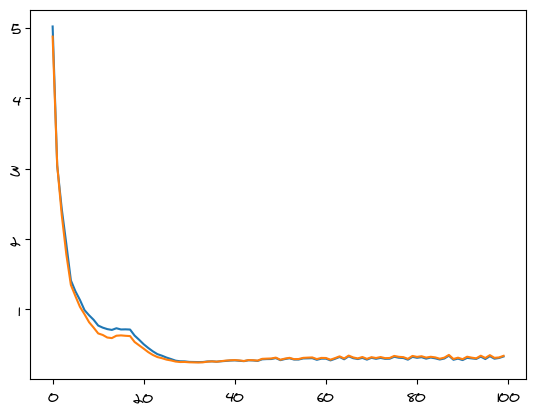

In [37]:
# plot losses
plt.plot(clf.history['train_logloss'])
plt.plot(clf.history['test_logloss'])

# # plot auc
# plt.plot(clf.history['test_gini'])
# # plot learning rates
# plt.plot(clf.history['lr'])

### Marginal plot

In [38]:
from plot_2d_interactions import plot_2d_interactions

/Users/deburky/Library/Caches/pypoetry/virtualenvs/lr-focal-loss-Opjerf94-py3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 95 (_) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


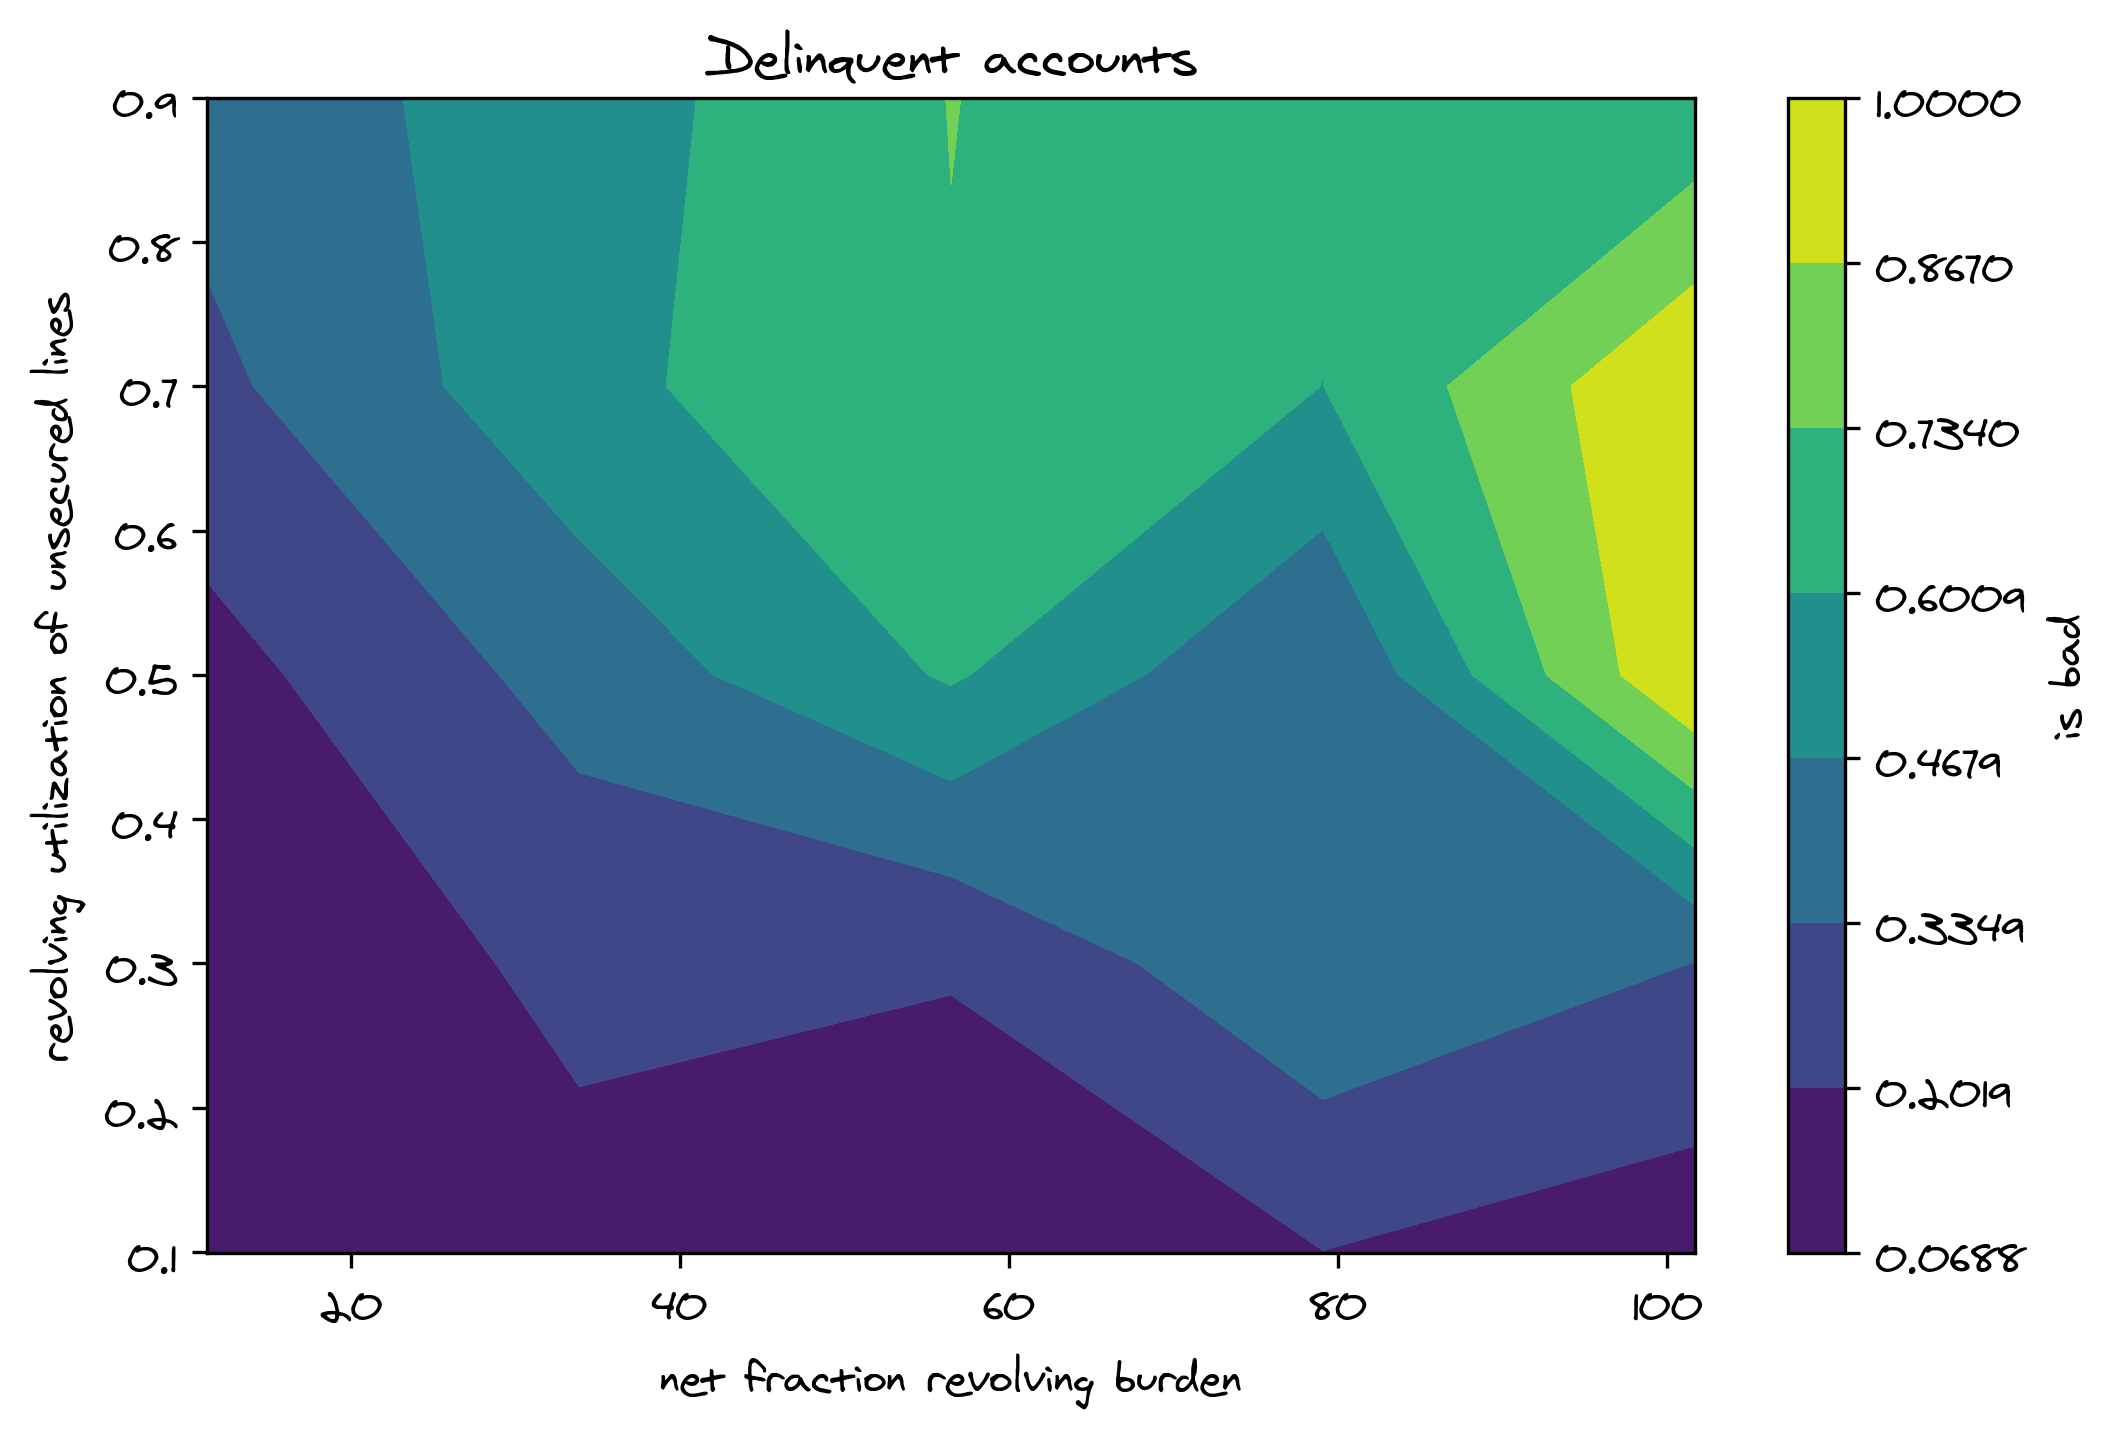

/Users/deburky/Library/Caches/pypoetry/virtualenvs/lr-focal-loss-Opjerf94-py3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 95 (_) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


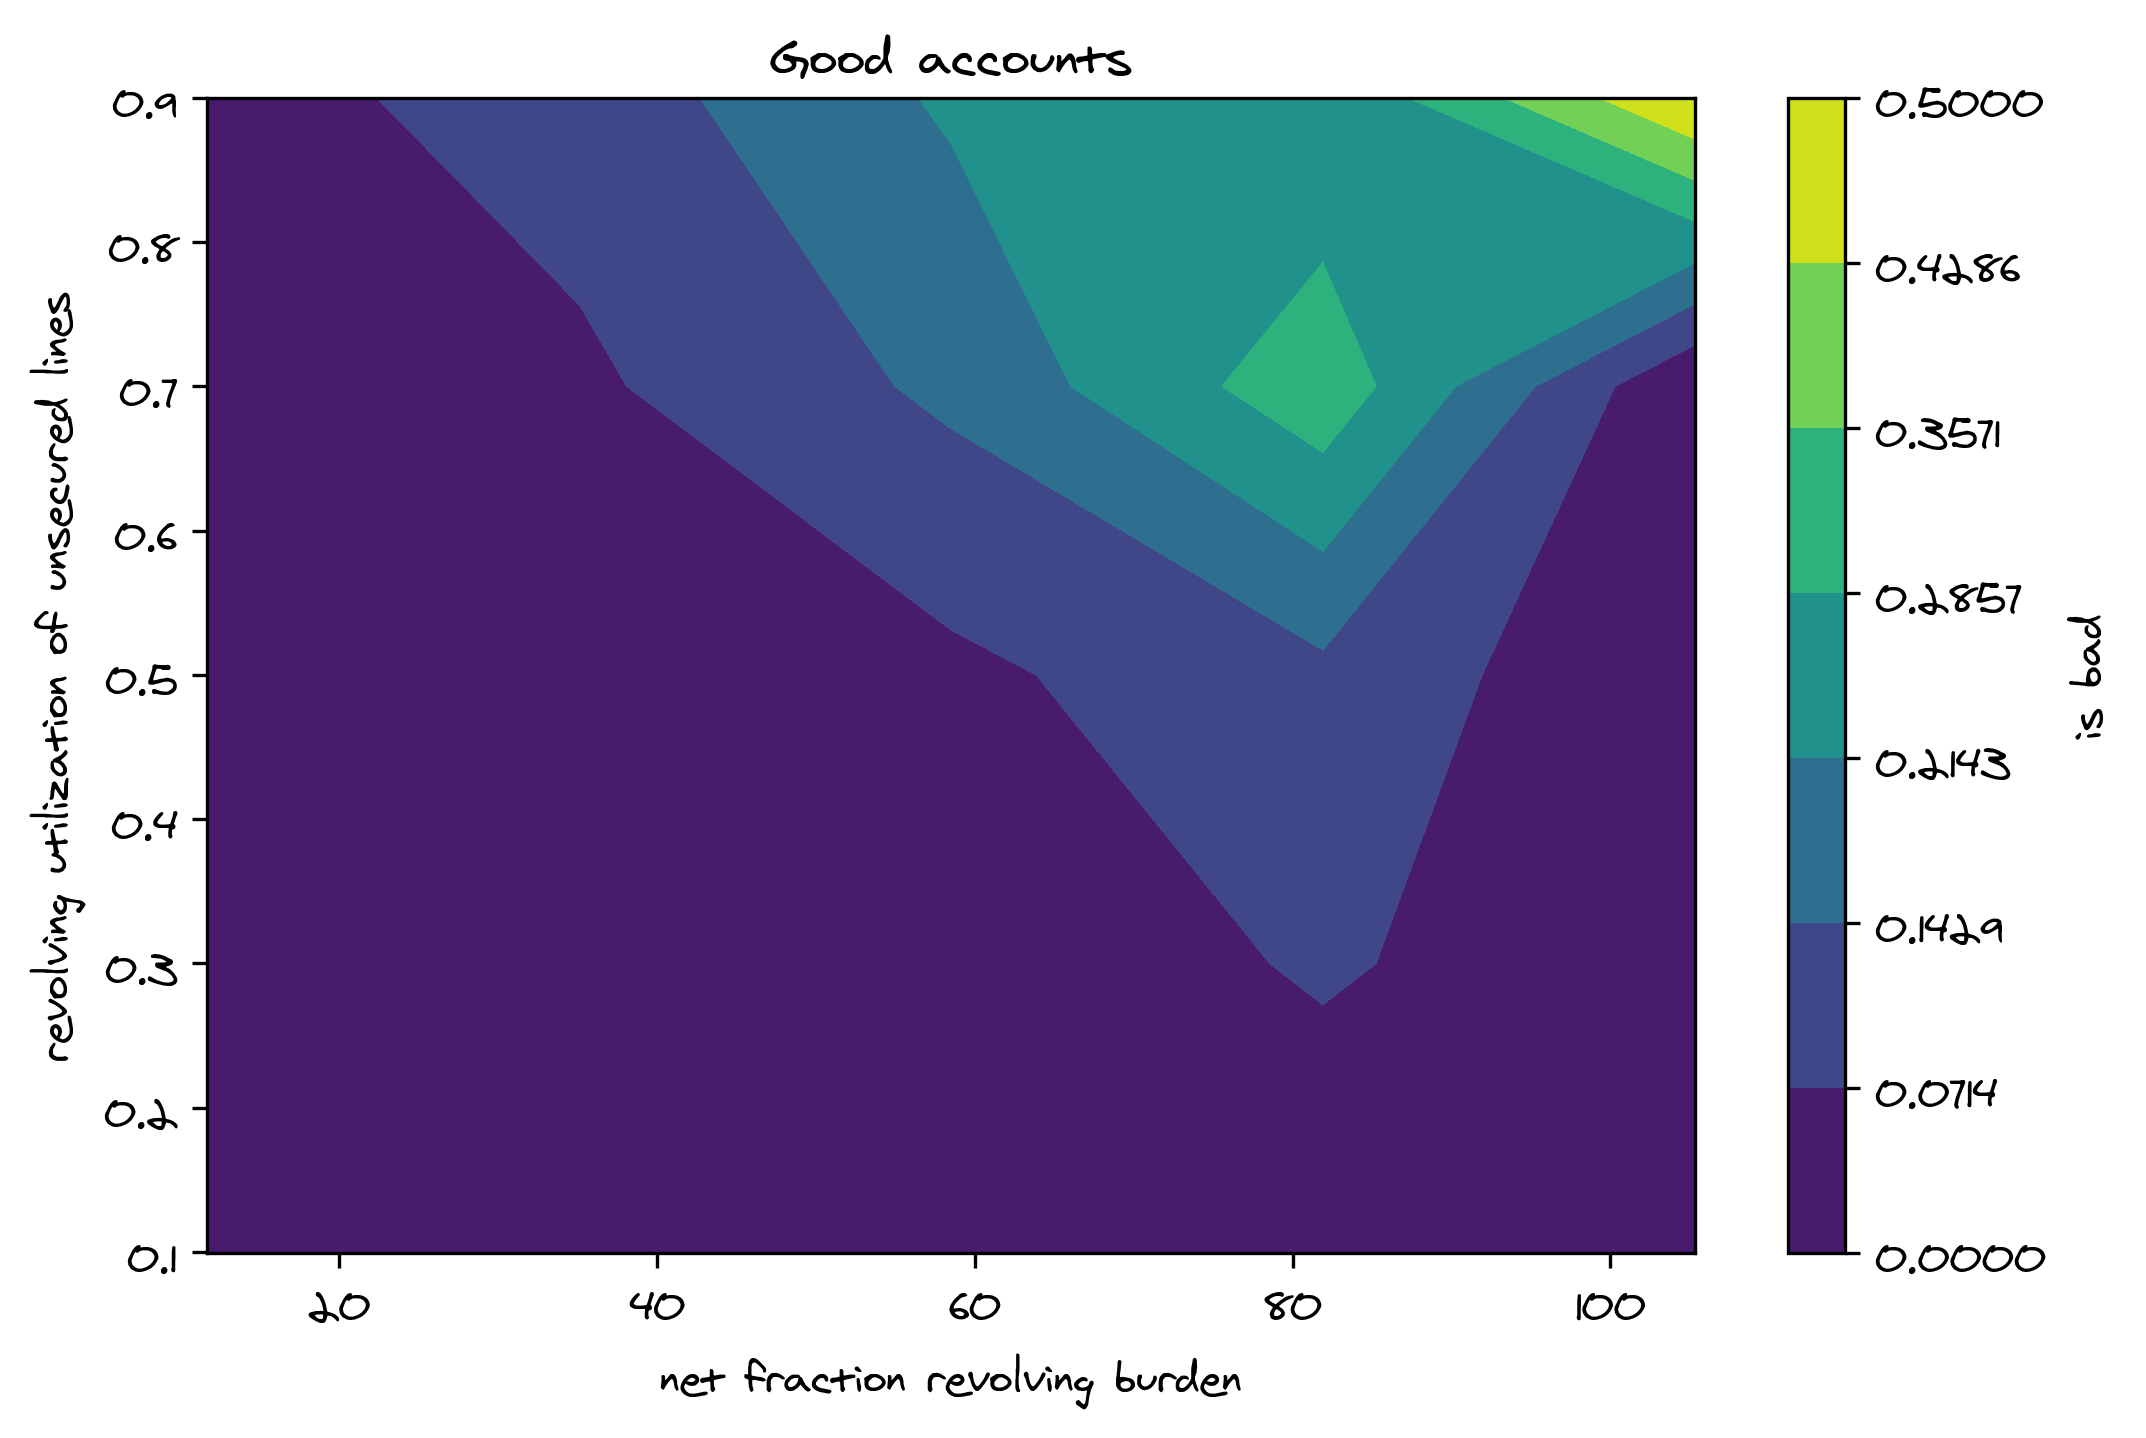

In [40]:
interactions_df = pd.concat([X.loc[ix_test], y.loc[ix_test]], axis=1)
filter_cond = interactions_df['account_never_delinq_percent'] < 95 # 5% of delinquent accounts

plot_2d_interactions(
    X=interactions_df[filter_cond], 
    features=['revolving_utilization_of_unsecured_lines', 'net_fraction_revolving_burden'], 
    y=interactions_df[filter_cond]['is_bad'], bins=5, plot_type='contour',  title='Delinquent accounts',
    figsize=(8,5), dpi=300)
plt.show()

plot_2d_interactions(
    X=interactions_df[~filter_cond], 
    features=['revolving_utilization_of_unsecured_lines', 'net_fraction_revolving_burden'], 
    y=interactions_df[~filter_cond]['is_bad'], bins=5, plot_type='contour', title='Good accounts',
    figsize=(8,5), dpi=300)
plt.show()